In [27]:
import numpy as np
import pandas as pd
df_bank = pd.read_csv('./dataset/BankCustomer.csv')
df_bank.head()

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Female,40,Beijing,9,2,0,1,516,6360.66,0.0000,0
1,Xue Baochai,Male,69,Beijing,6,2,0,1,682,28605.00,0.0000,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311.0932,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129909.8079,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976.1948,1


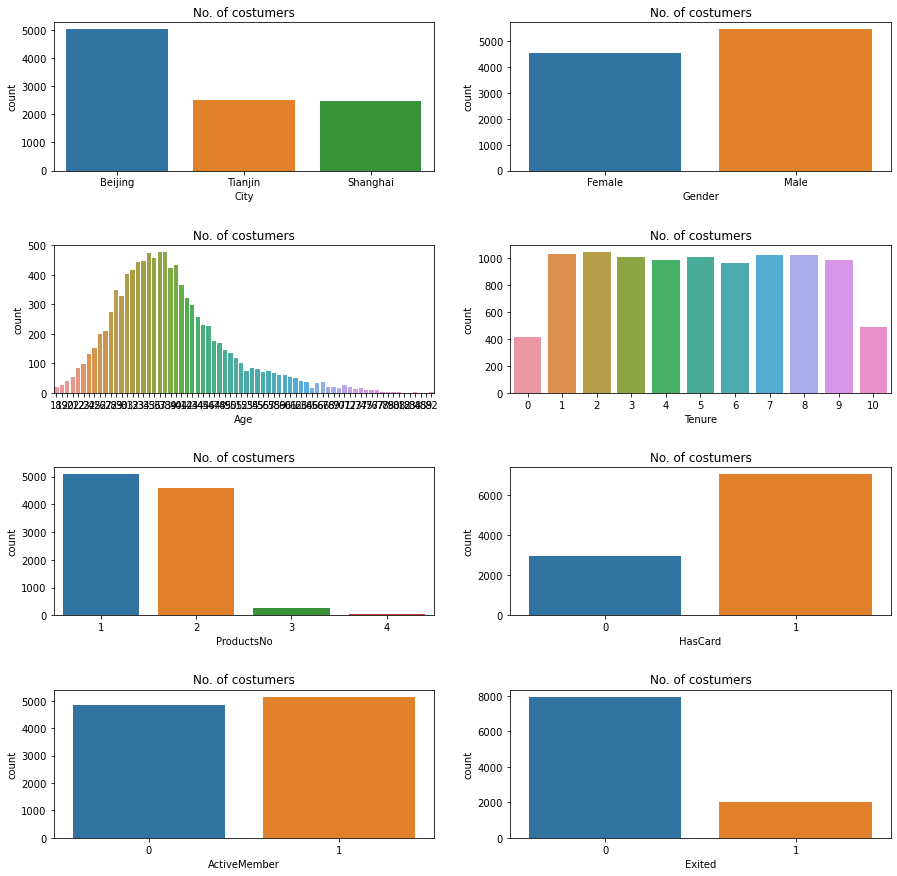

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# 显示不同特征的分布情况
features = ['City', 'Gender', 'Age', 'Tenure', 'ProductsNo', 'HasCard',
                        'ActiveMember', 'Exited']
fig = plt.subplots(figsize=(15, 15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.countplot(x=j, data=df_bank)
    plt.title("No. of costumers")

In [29]:
# 把二元类别文本数字化
df_bank['Gender'].replace("Female", 0, inplace = True)
df_bank['Gender'].replace("Male", 1, inplace = True)
# 显示数字类别
print("Gender unique values", df_bank['Gender'].unique())

Gender unique values [0 1]


In [30]:
# 把多元类别转换成多个二元哑变量，然后贴回原始数据集
d_city = pd.get_dummies(df_bank['City'], prefix="City")
df_bank = [df_bank, d_city]
df_bank = pd.concat(df_bank, axis = 1)
# 构建特征和标签集合
y = df_bank['Exited']
X = df_bank.drop(['Name', 'Exited', 'City'], axis = 1)
X.head()

,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,0,40,9,2,0,1,516,6360.66,0.0000,1,0,0
1,1,69,6,2,0,1,682,28605.00,0.0000,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311.0932,1,0,0
3,0,37,0,2,1,1,778,25564.01,129909.8079,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976.1948,0,0,1


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                                                                random_state=0)

In [32]:
# 对多棵决策树进行Bagging，即树的聚合
from sklearn.ensemble import BaggingClassifier # 导入Bagging分类器
from sklearn.tree import DecisionTreeClassifier # 导入决策树分类器
from sklearn.metrics import (f1_score, confusion_matrix) # 导入评估标准
dt = BaggingClassifier(DecisionTreeClassifier()) # 只使用一棵决策树
dt.fit(X_train, y_train) # 拟合模型
y_pred = dt.predict(X_test) # 进行预测
print("决策树测试准确率: {:.2f}%".format(dt.score(X_test, y_test)*100))
print("决策树测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))
bdt = BaggingClassifier(DecisionTreeClassifier()) #树的Bagging
bdt.fit(X_train, y_train) # 拟合模型
y_pred = bdt.predict(X_test) # 进行预测
print("决策树Bagging测试准确率: {:.2f}%".format(bdt.score(X_test, y_test)*100))
print("决策树Bagging测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

决策树测试准确率: 85.00%
决策树测试F1分数: 56.90%
决策树Bagging测试准确率: 85.20%
决策树Bagging测试F1分数: 57.23%


In [33]:
# 用网格搜索再进行参数优化
from sklearn.model_selection import GridSearchCV # 导入网格搜索工具
dbt_param_grid = {
    'base_estimator__max_depth': [5, 10, 20, 50, 100],
    'n_estimators': [1, 5, 10, 50]
}
dbt_gs = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
            param_grid = dbt_param_grid, scoring='f1',
            n_jobs=10, verbose=1)
dbt_gs.fit(X_train, y_train)
dbt_gs = dbt_gs.best_estimator_
y_pred = dbt_gs.predict(X_test)
print("决策树Bagging测试准确率: {:.2f}%".format(dbt_gs.score(X_test, y_test)*100))
print("决策树Bagging测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
决策树Bagging测试准确率: 86.00%
决策树Bagging测试F1分数: 58.46%


### 9.2.2 从树的聚合到随机森林

In [34]:
from sklearn.ensemble import RandomForestClassifier # 导入随机森林分类器
rf = RandomForestClassifier()
# 使用网格搜索优化参数
rf_param_grids = {"max_depth": [None],
                        "max_features": [1, 3, 10],
                        "min_samples_split":[2, 3, 10],
                        "min_samples_leaf": [1, 3, 10],
                        "bootstrap": [True, False],
                        "n_estimators": [100, 300],
                        "criterion": ["gini"]}
rf_gs = GridSearchCV(rf, param_grid = rf_param_grids,
                                        scoring = "f1", n_jobs=10, verbose=1)
rf_gs.fit(X_train, y_train)
rf_gs = rf_gs.best_estimator_
y_pred = rf_gs.predict(X_test)
print("随机森林测试准确率: {:.2f}%".format(rf_gs.score(X_test, y_test)*100))
print("随机森林测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100)) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits
随机森林测试准确率: 86.80%
随机森林测试F1分数: 61.18%


### 9.2.3 从随机森林到极端随机森林

In [35]:
from sklearn.ensemble import ExtraTreesClassifier # 导入极端随机森林分类器
ext = ExtraTreesClassifier()
# 使用网格搜索优化参数
ext_param_grids = {"max_depth": [None],
                        "max_features": [1, 3, 10],
                        "min_samples_split":[2, 3, 10],
                        "min_samples_leaf": [1, 3, 10],
                        "bootstrap": [True, False],
                        "n_estimators": [100, 300],
                        "criterion": ["gini"]}
ext_gs = GridSearchCV(ext, param_grid = ext_param_grids,
                                        scoring = "f1", n_jobs=4, verbose=1)
ext_gs.fit(X_train, y_train)
ext_gs = ext_gs.best_estimator_
y_pred = ext_gs.predict(X_test)
print("更多树测试准确率: {:.2f}%".format(ext_gs.score(X_test, y_test)*100))
print("更多树测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100)) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits
更多树测试准确率: 86.30%
更多树测试F1分数: 59.23%


### 9.3.1 Ada Boost算法

In [ ]:
from sklearn.ensemble import AdaBoostClassifier # 导入AdaBoost模型
dt = DecisionTreeClassifier()  # 选择决策树分类器作为AdaBoost的基准算法
ada = AdaBoostClassifier(dt)
# 使用网格化搜索优化参数
